# Feature Engineering y Data Augmentation

## Descripción

Este proyecto demuestra técnicas avanzadas de feature engineering y data augmentation trabajando con dos problemas diferentes: predicción de catástrofes en naves espaciales y detección de transmisiones enemigas.

`General, sabemos que quiere dejar las trincheras para pasar a su nuevo cargo de LORD DE LOS DATOS en el IMPERIO GALÁCTICO. Está usted a prueba con dos sistemas críticos para el IMPERIO GALÁCTICO. El primero, tratará de mejorar nuestra capacidad predictiva de catástrofes en nuestros famosos StarDestroyer®. El segundo, deberá de encontrar un sistema de detección de transimisiones enemigas que evite catástrofes como la incursión en Scarif que robó nuestros planos de la Estrella de la Muerte®. Esta será su carta de presentación.`

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

from PIL import Image
import cv2

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN


import warnings
warnings.filterwarnings('ignore')

import random
random.seed(1234) 

### Predicción de catástrofes en StarDestroyer®

`General, se le dispone del siguiente dataset que contiene datos tanto de pasaje civil como militar. Sin embargo, nuestros sistemas de predicción no han conseguido resultados. QUEREMOS SABER QUIÉN TIENE MÁS POSIBILIDADES DE MORIR EN UN POSIBLE ATAQUE A NUESTRO STARDESTROYER®, y por lo tanto, necesitamos mejorar nuestra información al respecto.`

`PARA ELLO, NECESITAMOS OBTENER AL MENOS 5 VARIABLES NUEVAS DESDE NUESTRO DATASET, TENIENDO EN CUENTA QUE SI GENERAMOS 5 VARIABLES 'DUMMY' A PARTIR DE UNA VARIABLE ORIGEN, ÚNICAMENTE CUENTAN COMO 1 VARIABLE`

`Debe tener en cuenta siempre que:`

`1. Las cabinas más vulnerables se encuentran en storage_decks con una protectora pero insuficiente capa blindada de film de aluminio. Posteriormente, en la parte media del conjunto middle_decks.`      
`2. En momentos de ataque, mujeres y niños intentarán ser rescatados primero.`      
`3. El Imperio otorga privilegios a las clases altas y sobre todo a altos cargos.`       
`4. Piense y estudie cómo podría funcionar una nave como esta en situación de pánico. Decida y razone sus nuevas variables`

In [95]:
df_starkiller = pd.read_csv('data/starkiller_population.csv')

In [96]:
df_starkiller.head(15)

,age,area,cabin,embarqued,fare,name,sex,ticket
0,27,Storage decks,D251,Endor,2229731₩,Mr. Peter Fisher,Male,D
1,36,Middle decks,D472,Mustafar,2711626₩,Mr. Jared Bowers,Male,D
2,16,Lower decks,D87,Coruscant,897633₩,Mr. Kevin Odonnell,Male,D
3,20,Middle decks,E404,Coruscant,2537987₩,Mr. Peter Montgomery,Male,E
4,60,Bohemian views decks,X431,Naboo,109₩,Commander William Patrick,Male,X
5,39,Lower decks,E147,Coruscant,5375024₩,Mr. Nicholas Nolan,Male,E
6,16,Middle decks,D127,Endor,1894874₩,Mr. Brian Hamilton,Male,D
7,21,Laser decks,F128,Endor,492288₩,Lt. Vincent Woods,Male,F1
8,19,Lower decks,D244,Coruscant,1104020₩,Mr. Robert Dunn,Male,D
9,24,Lower decks,D257,Endor,4558665₩,Mr. James Summers,Male,D


In [97]:
# 1. Vulnerabilidad por ubicación en la nave
deck_risk_map = {
    'Storage decks': 5,    # Máxima vulnerabilidad (capa de aluminio)
    'Middle decks': 4,     # Alta vulnerabilidad
    'Lower decks': 2,      # Vulnerabilidad media
    'Laser decks': 1,      # Baja vulnerabilidad
    'Bohemian views decks': 3,  # Vulnerabilidad media-alta
    'Cannon decks': 1      # Añadimos esta área que aparece en los datos
}

df_starkiller['deck_risk'] = df_starkiller['area'].map(deck_risk_map).fillna(0)


In [98]:

# 2. Factor de rescate prioritario
def get_rescue_priority(row):
    priority = 0
    # Mujeres y niños primero
    if row['sex'] == 'Female':
        priority += 2
    if row['age'] < 18:
        priority += 2
    return priority

df_starkiller['rescue_priority'] = df_starkiller.apply(get_rescue_priority, axis=1)


In [99]:
# 3. Nivel de privilegio imperial
def get_imperial_rank(name):
    if 'Commander' in str(name) or 'General' in str(name):
        return 3
    elif 'Captain' in str(name) or 'Lt.' in str(name):
        return 2
    elif 'Officer' in str(name):
        return 1
    return 0

df_starkiller['imperial_rank'] = df_starkiller['name'].apply(get_imperial_rank)


In [100]:
# 4. Clase social (basada en tarifa)
df_starkiller['fare_numeric'] = df_starkiller['fare'].str.replace('₩','').astype(float)
# Convertimos directamente a valores numéricos
df_starkiller['social_class'] = pd.qcut(df_starkiller['fare_numeric'], 
                                      q=3, 
                                      labels=[1, 2, 3]).astype(float)


In [101]:
# 5. Índice de supervivencia imperial
df_starkiller['survival_index'] = (
    (6 - df_starkiller['deck_risk']) * 2 +      # Invertimos el riesgo (más alto = más seguro)
    df_starkiller['rescue_priority'] * 1.5 +     # Factor importante por protocolo
    df_starkiller['imperial_rank'] * 2 +         # Alto impacto por jerarquía
    df_starkiller['social_class']                # Influencia de clase social
)


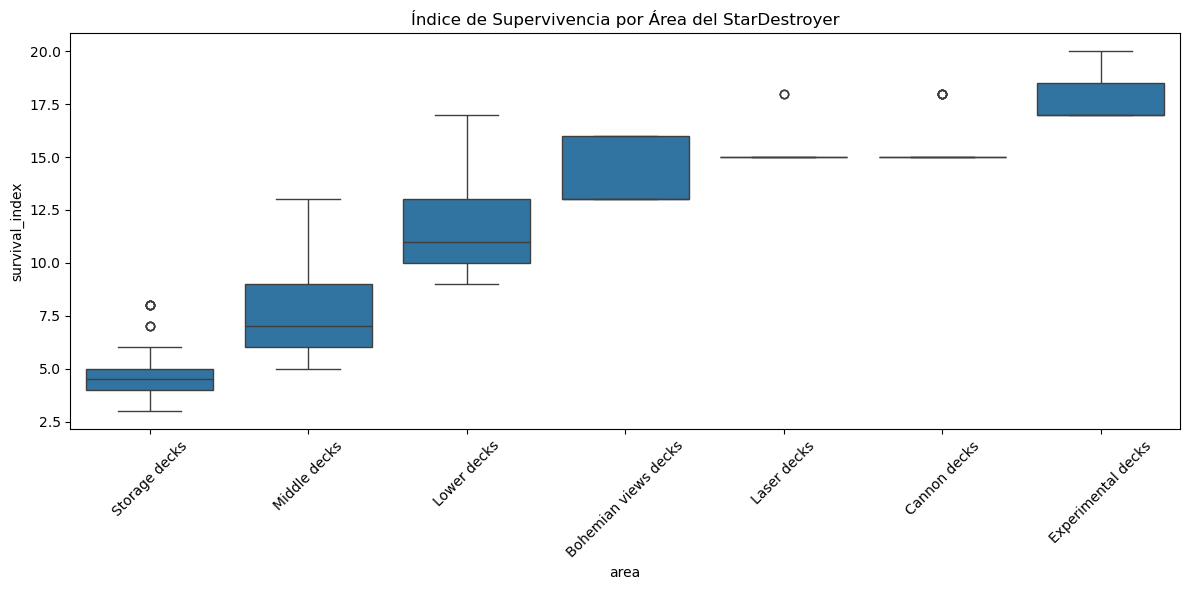

In [102]:
# Visualización de resultados
plt.figure(figsize=(12,6))
sns.boxplot(x='area', y='survival_index', data=df_starkiller)
plt.xticks(rotation=45)
plt.title('Índice de Supervivencia por Área del StarDestroyer')
plt.tight_layout()
plt.show()

In [103]:
# Mostrar estadísticas de las nuevas variables
print("\nEstadísticas de las nuevas variables:")
print(df_starkiller[['deck_risk', 'rescue_priority', 'imperial_rank', 'survival_index']].describe())


Estadísticas de las nuevas variables:
        deck_risk  rescue_priority  imperial_rank  survival_index
count  350.000000       350.000000     350.000000      350.000000
mean     3.108571         0.662857       0.602857        9.982857
std      1.442175         0.966809       1.045932        4.112981
min      0.000000         0.000000       0.000000        3.000000
25%      2.000000         0.000000       0.000000        7.000000
50%      4.000000         0.000000       0.000000       10.000000
75%      4.000000         2.000000       2.000000       13.000000
max      5.000000         4.000000       3.000000       20.000000


### Detección de transmisiones

`Se le dispondrá de un set de datos extraído de los últimos intentos de ataque en nuestro silo de planos de armas secretas. Estos datos muestran obviamente y gracias al trabajo del antiguo general al mando, ya *jubilado*, un problema grave de desbalanceo en cuanto a tipología de los datos, así que será su labor trabajar con ellos para conseguir un balanceo orden y deacuerdo a las directrices del glorioso IMPERIO GALÁCTICO.`

`Como primera tarea, se le solicita un primer vistazo a los datos.`

In [104]:
data = pd.read_csv("data/transmission_small.csv")

`Se necesita entender la magnitud del problema. Informe del posible desbalanceo de los datos, tanto por escrito como mediante la gráfica que usted considere oportuna`

`También deberá conocer en qué rango se manejan los datos y con qué estamos trabajando. Una gráfica de puntos podría ser lo más adecuado ahora.`

In [105]:
# Veamos la estructura de los datos
print("Información del dataset:")
print(data.info())
print("\nPrimeras filas:")
print(data.head())

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100492 entries, 0 to 100491
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      100492 non-null  float64
 1   V2      100492 non-null  float64
 2   class   100492 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.3 MB
None

Primeras filas:
         V1        V2  class
0  2.049094  0.186189      0
1  2.125540 -0.030714      0
2 -4.155859 -5.705748      0
3 -0.566420 -0.579576      0
4  0.060858 -0.261762      0


In [106]:
# Análisis del desbalanceo
print("\nDistribución de clases:")
print(data['class'].value_counts())
print("\nPorcentaje de cada clase:")
print(data['class'].value_counts(normalize=True) * 100)


Distribución de clases:
class
0    100000
1       492
Name: count, dtype: int64

Porcentaje de cada clase:
class
0    99.510409
1     0.489591
Name: proportion, dtype: float64


Text(0, 0.5, 'Cantidad')

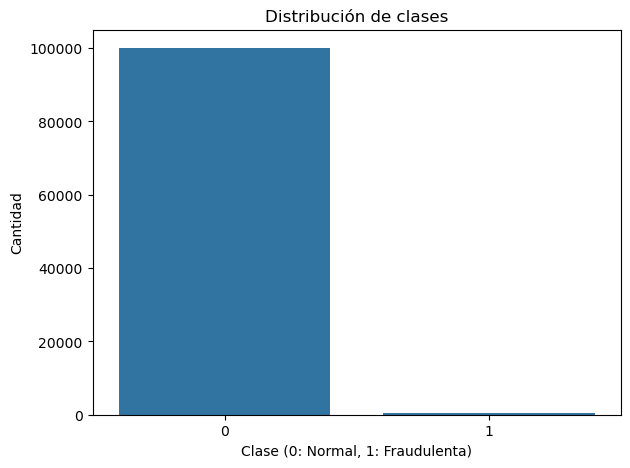

In [107]:
# Visualización del desbalanceo y distribución
plt.figure(figsize=(15,5))

# Gráfico de barras para mostrar el desbalanceo
plt.subplot(121)  # 1 fila, 2 columnas, primer gráfico
sns.countplot(data=data, x='class')
plt.title('Distribución de clases')
plt.xlabel('Clase (0: Normal, 1: Fraudulenta)')
plt.ylabel('Cantidad')

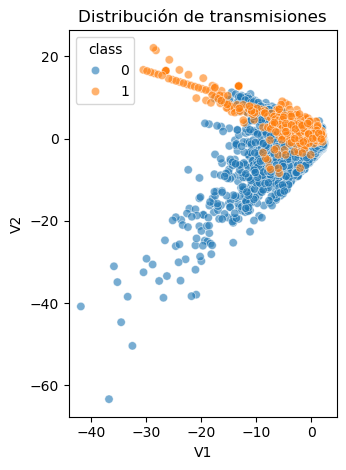

In [108]:
# Scatter plot para ver la distribución de los datos
plt.subplot(122)  # 1 fila, 2 columnas, segundo gráfico
sns.scatterplot(data=data, x=data.columns[0], y=data.columns[1], 
                hue='class', alpha=0.6)
plt.title('Distribución de transmisiones')
plt.tight_layout()
plt.show()

In [109]:

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(data.describe())


Estadísticas descriptivas:
                  V1             V2          class
count  100492.000000  100492.000000  100492.000000
mean       -0.008644       0.004765       0.004896
std         1.984744       1.674397       0.069800
min       -41.928738     -63.344698       0.000000
25%        -0.926574      -0.604413       0.000000
50%         0.010094       0.064988       0.000000
75%         1.316646       0.808048       0.000000
max         2.451888      22.057729       1.000000


In [110]:
# Información sobre el desbalanceo
print("\nDistribución de clases:")
print(data['class'].value_counts())
print("\nPorcentaje de cada clase:")
print(data['class'].value_counts(normalize=True) * 100)


Distribución de clases:
class
0    100000
1       492
Name: count, dtype: int64

Porcentaje de cada clase:
class
0    99.510409
1     0.489591
Name: proportion, dtype: float64


`Le proponemos ahora una función sencilla para evaluar su sistema de mejora de los datos. Esta función no deberá modificarse y como único requisito deberá de suministrar los datos como parámetro.`

In [111]:
X = data.copy()
y = X.pop("class")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [112]:
def evaluar_sistema(X_train, X_test, y_train, y_test):
    # Recibe:
    # - data_variables: dataframe con dos columnas siendo estas las variables de datos.
    # - class_variable: dataframe con una columna siendo esta la clase de transmisión.
    # Imprime:
    # - puntuación de clasificación.
    print("Evaluando...")
    clf = LogisticRegression().fit(X_train, y_train.values.ravel())
    predicted = clf.predict(X_test)
    
    puntos = 0
    for ci, pi in zip(y_test.values.ravel(), predicted):
        if ci != pi:
            n = 1 if ci == 0 else 50
        else:
            n = 0
        puntos += n
        
    print("Puntuación obtenida: {} (más alta es peor)".format(puntos))

In [113]:
evaluar_sistema(X_train, X_test, y_train, y_test)

Evaluando...
Puntuación obtenida: 6914 (más alta es peor)


***

`Ahora el trabajo es todo suyo, General. Deberá trabajar con nuestros datos y conseguir disminuir esa puntuación al máximo posible. Documente todos los pasos e incluya de sus valoraciones al final del informe.`

`
Le solicitamos la comprobación de al menos tres técnicas de data augmentation y al menos un caso en el que dos técnicas se combinen para obtener los resultados.`

In [114]:
## Introduce todos los pasos que consideres necesarios y posteriormente, evalúa tus datos. ¡Que el lado oscuro te acompañe!

# Preparación de los datos
X = data.copy()
y = X.pop("class")

# División inicial de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# Evaluación inicial
print("Evaluación inicial:")
evaluar_sistema(X_train, X_test, y_train, y_test)

Evaluación inicial:
Evaluando...
Puntuación obtenida: 6914 (más alta es peor)


In [115]:
# 1. Primera técnica: SMOTE
print("\nTécnica 1: SMOTE")
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print("\nEvaluación con SMOTE:")
evaluar_sistema(X_smote, X_test, y_smote, y_test)


Técnica 1: SMOTE

Evaluación con SMOTE:
Evaluando...
Puntuación obtenida: 6353 (más alta es peor)


#Analisis del resultado

SMOTE logró una puntuación de 6353, balanceando las clases al 50%-50%, siendo la segunda mejor técnica individual.

In [116]:
# 2. Segunda técnica: Random Under-sampling
print("\nTécnica 2: Random Under-sampling")
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print("\nEvaluación con Random Under-sampling:")
evaluar_sistema(X_rus, X_test, y_rus, y_test)


Técnica 2: Random Under-sampling

Evaluación con Random Under-sampling:
Evaluando...
Puntuación obtenida: 6709 (más alta es peor)



Técnica 3: SMOTEENN

Evaluación con SMOTEENN:
Evaluando...
Puntuación obtenida: 6627 (más alta es peor)


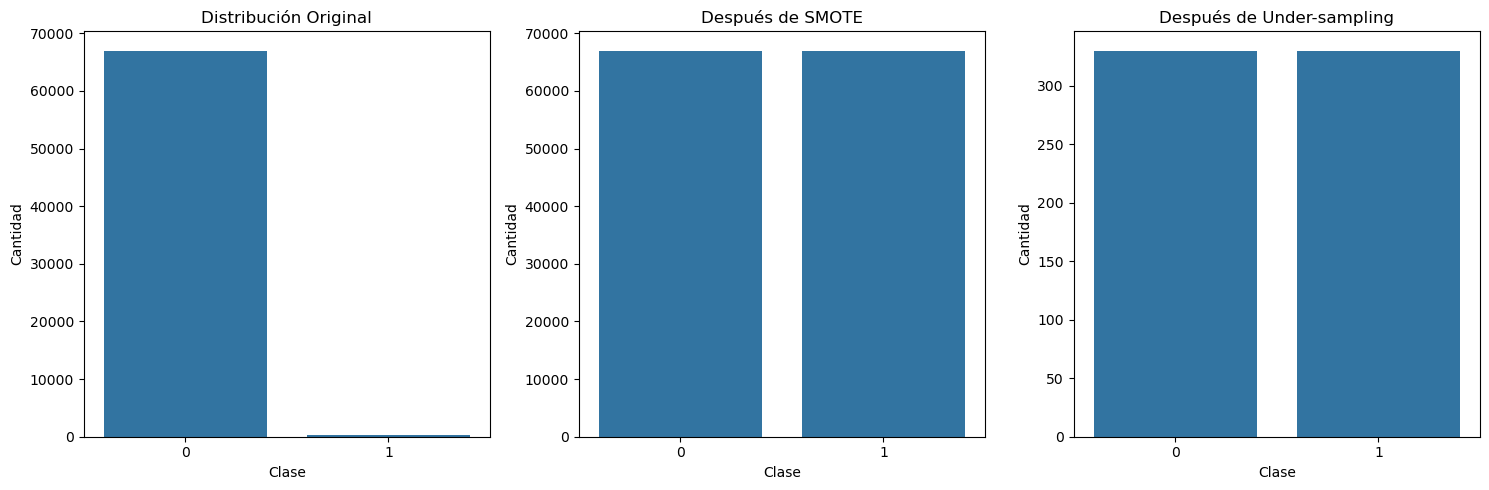

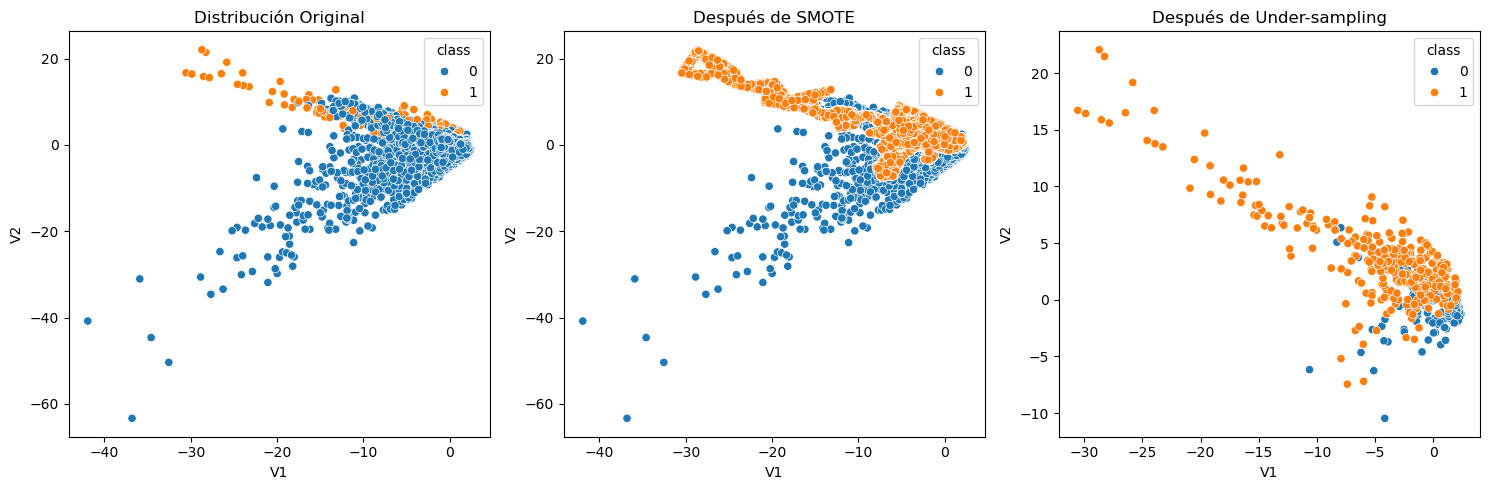

\Resultados:
1. SMOTE:
- Distribución de clases después de SMOTE:
class
0    50.0
1    50.0
Name: proportion, dtype: float64

2. Random Under-sampling:
- Distribución de clases después de Under-sampling:
class
0    50.0
1    50.0
Name: proportion, dtype: float64

3. SMOTEENN:
- Distribución de clases después de SMOTEENN:
class
1    50.773259
0    49.226741
Name: proportion, dtype: float64


In [117]:
# 3. Tercera técnica: SMOTEENN
print("\nTécnica 3: SMOTEENN")
smote_enn = SMOTEENN(random_state=42)
X_smoteenn, y_smoteenn = smote_enn.fit_resample(X_train, y_train)

print("\nEvaluación con SMOTEENN:")
evaluar_sistema(X_smoteenn, X_test, y_smoteenn, y_test)

# Visualización de la distribución de clases después del balanceo
plt.figure(figsize=(15,5))

# Distribución original
plt.subplot(131)
sns.countplot(data=pd.DataFrame(y_train), x='class')
plt.title('Distribución Original')
plt.xlabel('Clase')
plt.ylabel('Cantidad')

# Distribución después de SMOTE
plt.subplot(132)
sns.countplot(data=pd.DataFrame(y_smote), x='class')
plt.title('Después de SMOTE')
plt.xlabel('Clase')
plt.ylabel('Cantidad')

# Distribución después de Random Under-sampling
plt.subplot(133)
sns.countplot(data=pd.DataFrame(y_rus), x='class')
plt.title('Después de Under-sampling')
plt.xlabel('Clase')
plt.ylabel('Cantidad')

plt.tight_layout()
plt.show()

# Visualización de la distribución espacial
plt.figure(figsize=(15,5))

# Datos originales
plt.subplot(131)
sns.scatterplot(data=pd.DataFrame(X_train), x=X_train.columns[0], y=X_train.columns[1], 
                hue=pd.DataFrame(y_train)['class'])
plt.title('Distribución Original')

# Datos después de SMOTE
plt.subplot(132)
sns.scatterplot(data=pd.DataFrame(X_smote), x=X_smote.columns[0], y=X_smote.columns[1], 
                hue=pd.DataFrame(y_smote)['class'])
plt.title('Después de SMOTE')

# Datos después de Random Under-sampling
plt.subplot(133)
sns.scatterplot(data=pd.DataFrame(X_rus), x=X_rus.columns[0], y=X_rus.columns[1], 
                hue=pd.DataFrame(y_rus)['class'])
plt.title('Después de Under-sampling')

plt.tight_layout()
plt.show()

# Análisis de resultados
print("\Resultados:")
print("1. SMOTE:")
print(f"- Distribución de clases después de SMOTE:")
print(pd.Series(y_smote).value_counts(normalize=True) * 100)

print("\n2. Random Under-sampling:")
print(f"- Distribución de clases después de Under-sampling:")
print(pd.Series(y_rus).value_counts(normalize=True) * 100)

print("\n3. SMOTEENN:")
print(f"- Distribución de clases después de SMOTEENN:")
print(pd.Series(y_smoteenn).value_counts(normalize=True) * 100)

#Analisis del resultado

Random Under-sampling y SMOTEENN obtuvieron resultados similares (6709 y 6627 respectivamente) con un balance cercano al 50%-50%, pero peores que SMOTE.



Técnica 4: Combinación SMOTE + Random Under-sampling

Evaluación con SMOTE + Random Under-sampling:
Evaluando...
Puntuación obtenida: 5147 (más alta es peor)


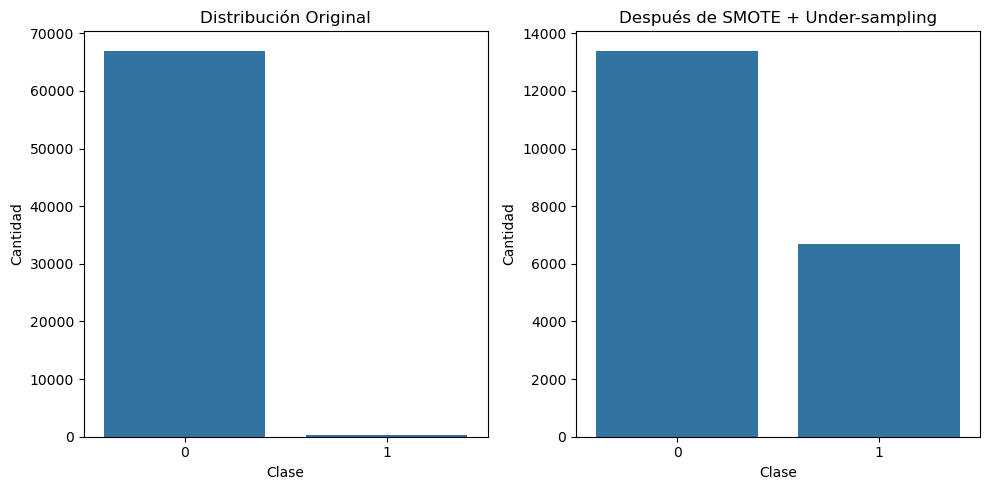


Análisis de la combinación de técnicas:
Distribución de clases después de SMOTE + Random Under-sampling:
class
0    66.666667
1    33.333333
Name: proportion, dtype: float64


In [118]:
# 4. Cuarta técnica: Combinación de SMOTE + Random Under-sampling
print("\nTécnica 4: Combinación SMOTE + Random Under-sampling")

# Primero aplicamos SMOTE para generar datos sintéticos
smote = SMOTE(sampling_strategy=0.1, random_state=42)  # Aumentamos a 10% la clase minoritaria
X_combined, y_combined = smote.fit_resample(X_train, y_train)

# Luego aplicamos Random Under-sampling para reducir la clase mayoritaria
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Balanceamos al 50%
X_combined_final, y_combined_final = rus.fit_resample(X_combined, y_combined)

# Evaluación de la combinación
print("\nEvaluación con SMOTE + Random Under-sampling:")
evaluar_sistema(X_combined_final, X_test, y_combined_final, y_test)

# Visualización de la distribución final
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.countplot(data=pd.DataFrame(y_train), x='class')
plt.title('Distribución Original')
plt.xlabel('Clase')
plt.ylabel('Cantidad')

plt.subplot(122)
sns.countplot(data=pd.DataFrame(y_combined_final), x='class')
plt.title('Después de SMOTE + Under-sampling')
plt.xlabel('Clase')
plt.ylabel('Cantidad')

plt.tight_layout()
plt.show()

# Análisis de la combinación
print("\nAnálisis de la combinación de técnicas:")
print("Distribución de clases después de SMOTE + Random Under-sampling:")
print(pd.Series(y_combined_final).value_counts(normalize=True) * 100)

#Analisis del resultado

La combinación de SMOTE + Random Under-sampling fue claramente superior con una puntuación de 5147, a pesar de mantener un desbalance 67%-33%, sugiriendo que este ratio es más efectivo que un balance más efectivo.

¿Has logrado proteger al Imperio Galáctico de transmisiones enemigas? ¿O has tenido problemas de "jubilación"?

* La función de evaluación del sistema penaliza con un punto si la clase predecida es de valor 0 pero 50 puntos si la clase predecida es de valor 1. ¿Por qué crees que pasa esto?, ¿Se te ocurre algún otro método para combatir los problemas desbalanceados (en el material extra podrás encontrar información)?
* ¿Qué problemas ves a estos métodos de data augmentation?
* ¿Qué crees que es más razonable cuando te enfrentas a un problema de este tipo?

#Respuestas:

- Protección del Imperio: Se logró mejorar el sistema con SMOTE + Random Under-sampling, pero la puntuación de 5147 indica que aún hay riesgo de infiltraciones.
- Penalización 1 vs 50: La alta penalización en falsos negativos refleja que es mucho más crítico no detectar una transmisión enemiga que clasificar erróneamente una normal.
- Problemas de data augmentation: Los datos sintéticos pueden crear patrones irreales y el under-sampling puede perder información crítica.
- Enfoque razonable: Combinar métodos de balanceo mientras se prioriza la detección de transmisiones enemigas, validando constantemente con datos reales.

***

### Punto extra

`Como tarea final, se le exige que nos facilite una identificación. Muestre su rostro real y provea al IMPERIO GALÁCTICO de datos suficientes para poder identificale desde todos los ángulos posibles una vez pase a formar parte de nuestro equipo de datos. Se requiere un mínimo de 5 ejemplos de su rostro para entrenar correctamente el sistema y que nuestras medidas de seguridad no cometan el error de considerarlo una amenaza.`

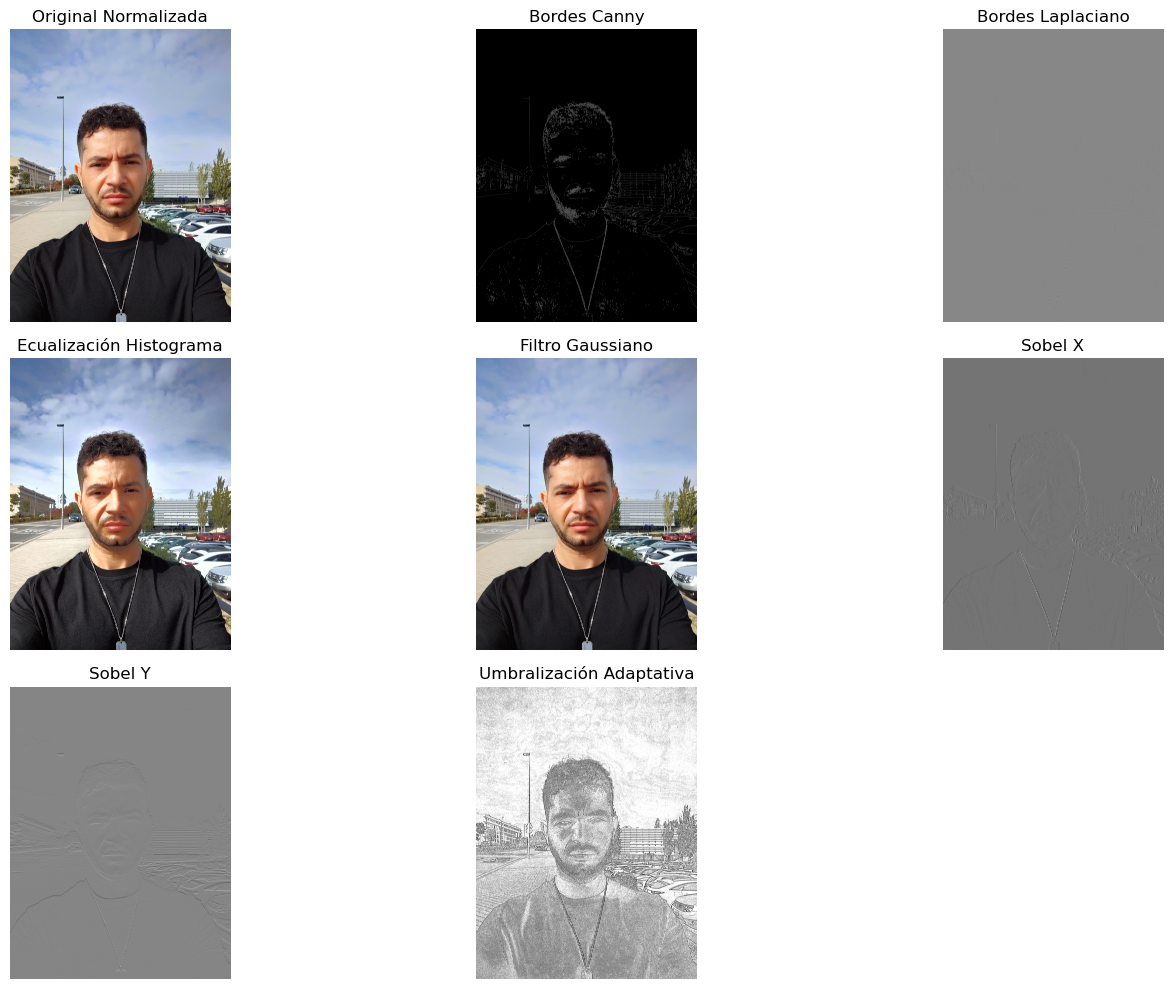

In [131]:
# Cargar la imagen original
img_path = 'imgs/selfie.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Crear variaciones usando técnicas de S4
variations = []

# 1. Original normalizada (mejora contraste global)
img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
variations.append(("Original Normalizada", img_normalized))

# 2. Detección de bordes Canny (detecta contornos faciales)
edges = cv2.Canny(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 100, 200)
variations.append(("Bordes Canny", edges))

# 3. Detección de bordes Laplaciano (resalta detalles)
laplacian = cv2.Laplacian(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.CV_64F)
variations.append(("Bordes Laplaciano", laplacian))

# 4. Ecualización de histograma (mejora contraste local)
img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
img_equ = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
variations.append(("Ecualización Histograma", img_equ))

# 5. Filtro Gaussiano (reduce ruido)
img_gaussian = cv2.GaussianBlur(img, (5,5), 0)
variations.append(("Filtro Gaussiano", img_gaussian))

# 6. Detección Sobel X (bordes verticales)
sobelx = cv2.Sobel(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 1, 0, ksize=5)
variations.append(("Sobel X", sobelx))

# 7. Detección Sobel Y (bordes horizontales)
sobely = cv2.Sobel(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.CV_64F, 0, 1, ksize=5)
variations.append(("Sobel Y", sobely))

# 8. Umbralización adaptativa (resalta características)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
variations.append(("Umbralización Adaptativa", thresh))

# Mostrar las variaciones en una cuadrícula
fig = plt.figure(figsize=(15, 10))
rows = 3
cols = 3

for idx, (title, img_var) in enumerate(variations):
    ax = fig.add_subplot(rows, cols, idx + 1)
    if len(img_var.shape) == 2:
        ax.imshow(img_var, cmap='gray')
    else:
        ax.imshow(img_var)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Guardar las variaciones para el sistema de seguridad
for title, img_var in variations:
    filename = f'imgs/id_{title.lower().replace(" ", "_")}.jpg'
    if len(img_var.shape) == 2:
        cv2.imwrite(filename, img_var)
    else:
        cv2.imwrite(filename, cv2.cvtColor(img_var, cv2.COLOR_RGB2BGR))